In [ ]:
### I need breast cancer dataset
### use pretrained model to classify it


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

data = load_breast_cancer()
X, y = data.data, data.target
class_names = data.target_names


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


X_padded = np.pad(X_scaled, ((0, 0), (0, 1024 - 30)), mode='constant')
X_images = X_padded.reshape(-1, 32, 32, 1)

X_images = np.repeat(X_images, 3, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(X_images, y, test_size=0.2, random_state=42)



base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Training the VGG-based model on numerical data...")
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)


predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()


actual_labels = [class_names[i] for i in y_test]
predicted_labels = [class_names[i] for i in predictions]

print("\n--- Final Results ---")
print(classification_report(y_test, predictions, target_names=class_names))


results_df = pd.DataFrame({'Actual': actual_labels, 'Predicted': predicted_labels})
print("\nSample Output:")
print(results_df.head(10)) #

Training the VGG-based model on numerical data...
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step

--- Final Results ---
              precision    recall  f1-score   support

   malignant       0.98      0.95      0.96        43
      benign       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Sample Output:
      Actual  Predicted
0     benign     benign
1  malignant  malignant
2  malignant  malignant
3     benign     benign
4     benign     benign
5  malignant  malignant
6  malignant  malignant
7  malignant  malignant
8     benign  malignant
9     benign     benign


Class distribution in sample:
label
0    14307
1     5693
Name: count, dtype: int64
Found 12800 validated image filenames belonging to 2 classes.
Found 3200 validated image filenames belonging to 2 classes.
Training on 12800 samples, Validating on 3200 samples...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.7012 - loss: 0.5781 - val_accuracy: 0.7987 - val_loss: 0.4595
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.7875 - loss: 0.4781 - val_accuracy: 0.8144 - val_loss: 0.4360
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 397s 993ms/step - accuracy: 0.8039 - loss: 0.4586 - val_accuracy: 0.8169 - val_loss: 0.4286
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 403s 1s/step - accuracy: 0.8099 - loss: 0.4396 - val_accuracy: 0.8153 - val_loss: 0.4257
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 393s 983ms/step - accuracy: 0.8078 - loss: 0.4373 - val_accuracy: 0.8216 - val_loss: 0.4203
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 396s 991ms/step - accuracy: 0.8149 - loss: 0.4305 - val_accuracy: 0.8253 - val_loss: 0.4156
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 396s 991ms/step - accuracy: 0.8138 - loss: 0.4203 - val_accuracy: 0.8266 - val_loss: 0.4137
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 394s 985ms/step - accuracy: 0.8147 - loss: 0.

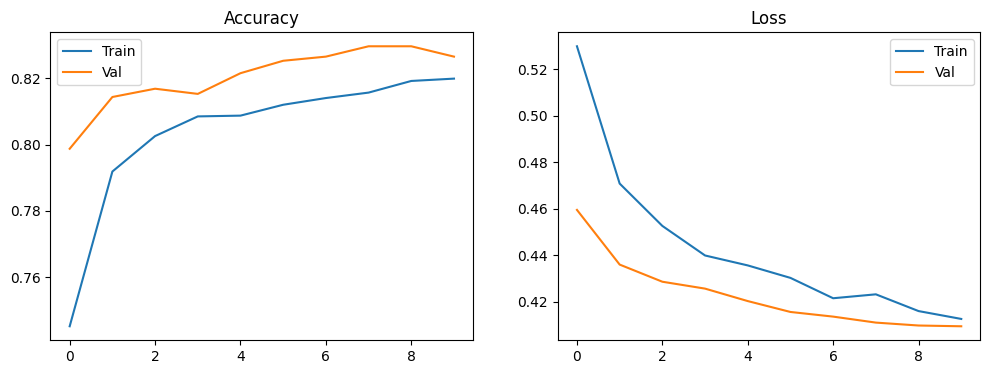

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers


path = "/root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1"

all_images = glob(os.path.join(path, '**/*.png'), recursive=True)

def get_label(file_path):
    parts = file_path.split(os.sep)
    return '1' if '1' in parts[-2] else '0'

data_df = pd.DataFrame({
    'path': all_images,
    'label': [get_label(p) for p in all_images]
})

data_df = data_df.sample(frac=1, random_state=42).reset_index(drop=True)
data_df = data_df.head(20000)
data_df['label'] = data_df['label'].astype(str)

print("Class distribution in sample:")
print(data_df['label'].value_counts())


train_full_df, test_df = train_test_split(data_df, test_size=0.2, stratify=data_df['label'], random_state=42)


train_df, val_df = train_test_split(train_full_df, test_size=0.2, stratify=train_full_df['label'], random_state=42)


datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label',
    target_size=(50, 50), batch_size=32, class_mode='binary'
)

val_gen = datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label',
    target_size=(50, 50), batch_size=32, class_mode='binary'
)


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])


print(f"Training on {len(train_df)} samples, Validating on {len(val_df)} samples...")
history = model.fit(train_gen, epochs=10, validation_data=val_gen)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()
